In [ ]:
!pip install transformers datasets scikit-learn kagglehub


In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, ConfusionMatrixDisplay
)
from nltk.stem import WordNetLemmatizer
import joblib
import re
import os
import kagglehub

In [12]:
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\shivani\.cache\kagglehub\datasets\crowdflower\twitter-airline-sentiment\versions\4


In [13]:
df = pd.read_csv(f"{path}/Tweets.csv")

In [14]:
lemmatizer=WordNetLemmatizer()

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\bnot bad\b', 'good', text)
    text = re.sub(r'\bbut packaging was average\b', 'neutral_packaging', text)
    text = re.sub(r'\s+', ' ', text).strip()  
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [16]:
df['text'] = df['text'].apply(clean_text)
print("Text cleaning completed!")

Text cleaning completed!


In [17]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(sentiment_mapping)

In [18]:
print("Sentiment Mapping:")
print(sentiment_mapping)

Sentiment Mapping:
{'negative': 0, 'neutral': 1, 'positive': 2}


In [19]:
print(df['label'].value_counts())

label
0    9178
1    3099
2    2363
Name: count, dtype: int64


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

In [21]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english',ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [22]:
print(f"Number of features: {X_train_tfidf.shape[1]}")

Number of features: 10000


In [23]:
classifier = RandomForestClassifier(n_estimators=300,random_state=42 , class_weight='balanced_subsample',max_depth=None,min_samples_split=5, min_samples_leaf=2) 
classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=300, random_state=42)

In [24]:
y_pred = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [25]:
print("\nModel Performance:")
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")


Model Performance:
🔹 Accuracy: 0.7575
🔹 Precision: 0.7719
🔹 Recall: 0.7575
🔹 F1 Score: 0.7631


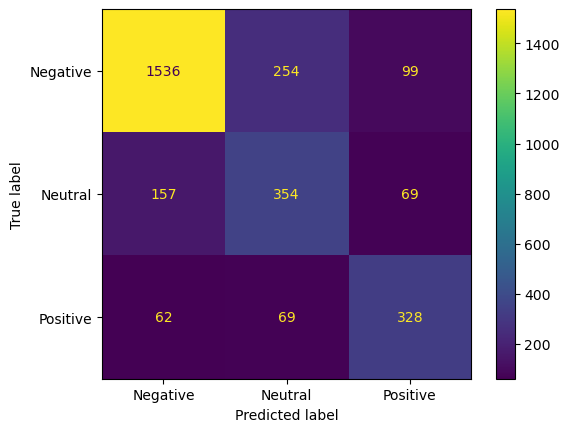

In [26]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()

In [27]:
os.makedirs("./fine_tuned_model", exist_ok=True)


In [28]:
joblib.dump(classifier, "./fine_tuned_model/sentiment_classifier.pkl")
joblib.dump(vectorizer, "./fine_tuned_model/vectorizer.pkl")
print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [29]:
def predict_sentiment(text):
    clean_text_input = clean_text(text)
    input_tfidf = vectorizer.transform([clean_text_input])
    prediction = np.argmax(classifier.predict_proba(input_tfidf), axis=1)[0]
    labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return labels[prediction]

In [30]:
print(predict_sentiment("The product works fine, but the delivery was late."))   
print(predict_sentiment("It’s acceptable for the price."))  
print(predict_sentiment("I absolutely love the customer service here."))  
print(predict_sentiment("Absolutely awful. A complete waste of money."))  
print(predict_sentiment("Horrible experience. I regret this purchase."))  

Negative
Neutral
Negative
Negative
Negative
